# ATP Tennis - Advanced Feature Engineering

In previous notebook we created features based on data that was already provided for the match.

In this notebook, we will add to this dataset by created features that represents player matchup and player history as I think this should help us with our model

## Player History

We will create features that represent player matches leading up to that match we are predicting. Not all of these columns will be used in our model - most likely I will only use the percentages in our models but the data is there can we can filter them out later

We are currently only looking back 5 matches leading up to our current match we are trying to predict

### Features Created
* wins - matches won
* losses - matches lost
* games won
* sets won
* games lost
* sets lost
* winning percentage = wins / (wins + losses)
* games won percetnage = games won / (games won + games lost)
* sets won percentage = sets won / (sets won + sets lost)

## Player Matchup
We will create features that represent match-up history - ie, whether p1 defeated p2, score, etc. Currently, we are only looking back up to 5 matchups

## Features Created
* matchups won - ie, out of last 5 matchups - how many matches did p1 win
* matchups lost
* matchups sets won
* matchups sets lost
* matchups games won
* matchups games lost
* matchups win percentage
* matchups sets won percentage
* matchups games won percentage



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import json
from datetime import datetime, date
from sys import path
from os.path import dirname as dir
import re
from pprint import pprint
import traceback
import sys

path.append(dir('../'))

# from util import score_util

# from util.score_util import process_scores
# import importlib
# importlib.reload(util.score_util)

import logging

%matplotlib inline
sns.set()

In [2]:
# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

# Contants
START_YEAR = 1985
END_YEAR = 2019

# files
DATASET_DIR = '../datasets'
# this is the file we generated from our pre-processing notebook
PREPROCESSED_FILE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_preprocessed.csv'

FEATURE_FILE_1985 = f'{DATASET_DIR}/atp_matches_1985-2019_features.csv'
FEATURE_FILE_1985_DIFF = f'{DATASET_DIR}/atp_matches_1985-2019_features-diff.csv'
FEATURE_FILE_1985_DIFF_OHE = f'{DATASET_DIR}/atp_matches_1985-2019_features-diff-ohe.csv'

# output info
MODEL_DIR = '../models'
MODEL_FILE = f'{MODEL_DIR}/{DATE}-lr.csv'
MODEL_FILE = f'{MODEL_DIR}/{DATE}-lr-diff.csv'

REPORT_DIR = '../reports'
REFPORT_FILE = f'{REPORT_DIR}/report.csv'

LABEL_COL = 'p1_winner'

# random seed
RSTATE = 1
N_JOBS = 4
MAX_ITER = 1000
LEADING_MATCHES = 5



In [3]:
preprocessed = pd.read_csv(PREPROCESSED_FILE, parse_dates=["tourney_date"])
feature1985 = pd.read_csv(FEATURE_FILE_1985)

In [27]:



logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

def process_scores(scores: str, idx: str = None):
    """
    Use this to parse out differnt parts of a match score.
    Will be using this for feature Engineering as input to predict match results

    :param scores: - string with scores - ie, 6-7 7-6(7) 6-3
    "param idx": - optional entry with row index - used for debugging since some of the scores look to have been converted to date (ie, 3-jun)

    :return:
        winner_sets_won
        winner_games_won
        loser_sets_won
        loser_games_won
    """
    scores_orig = scores
    set_score = [0, 0]
    game_score = [0, 0]
    try:
        scores = re.sub(r"[^0-9-\ ]","", scores).strip()
        log.debug(f'scores {scores_orig} cleaned scores {scores}')
        sets = scores.split()
        for set in sets:
            p1 = int(set.split("-")[0])
            p2 = int(set.split("-")[1])
            game_score[0] += p1
            game_score[1] += p2
            if p1 > p2:
                set_score[0] += 1
            else:
                set_score[1] += 1
    except Exception as e:
        raise Exception(f'orig score {scores_orig} scores {scores}') from e
        

    return set_score[0], game_score[0], set_score[1], game_score[1]

def get_player_matches(matches: pd.DataFrame, player_id: str, tourney_date: datetime, num_matches: int):
    return matches[((matches.winner_id == player_id) | (matches.loser_id == player_id)) &
                  (matches.score.notnull()) &
                  (matches.tourney_date < tourney_date)][-num_matches:]

def get_match_ups(matches: pd.DataFrame, p1_id: str, p2_id: str, tourney_date: datetime, num_matches: int):
    matchups = matches[
        (((matches.winner_id == p1_id) & (matches.loser_id == p2_id)) |
        ((matches.winner_id == p2_id) & (matches.loser_id == p1_id))) &
        (matches.tourney_date < tourney_date) &
        (matches.score.notnull())
    ][-num_matches:]
    return matchups

scores = pd.DataFrame()
for index, row in feature1985.iterrows():
    try:
        # get player record leading up to this match
        p1_history_wins, p1_history_losses, p1_history_sets_won, p1_history_games_won, p1_history_sets_lost, p1_history_games_lost = 0, 0, 0, 0, 0, 0
        p2_history_wins, p2_history_losses, p2_history_sets_won, p2_history_games_won, p2_history_sets_lost, p2_history_games_lost = 0, 0, 0, 0, 0, 0
        p1_matchup_wins, p1_matchup_losses, p1_matchup_sets_won, p1_matchup_games_won = 0, 0, 0, 0
        p2_matchup_wins, p2_matchup_losses, p2_matchup_sets_won, p2_matchup_games_won = 0, 0, 0, 0
        log.debug(f'index {index} tourney_year {row.tourney_year} tourney_month {row.tourney_month}')
        for index, match in get_player_matches(preprocessed, row.p1, 
                                               datetime(int(row.tourney_year), int(row.tourney_month), 1), LEADING_MATCHES).iterrows():
            log.debug(f'index {index} p1 {row.p1}')
            if match.winner_id == row.p1:
                log.debug('p1 winner')
                p1_history_wins += 1
                ws, wg, ls, lg = process_scores(match.score, index)
                p1_history_sets_won += ws
                p1_history_games_won += wg
                p1_history_sets_lost += ls
                p1_history_games_lost += lg
            else:
                log.debug('p1 loser')
                p1_history_losses += 1
                ws, wg, ls, lg = process_scores(match.score, index)
                p1_history_sets_won += ls
                p1_history_games_won += lg
                p1_history_sets_lost += ws
                p1_history_games_lost += wg
        for index, match in get_player_matches(preprocessed, row.p2, 
                                               datetime(int(row.tourney_year), int(row.tourney_month), 1), LEADING_MATCHES).iterrows():
            log.debug(f'index {index} p2 {row.p2}')
            if match.winner_id == row.p2:
                log.debug('p2 winner')
                p2_history_wins += 1
                ws, wg, ls, lg = process_scores(match.score, index)
                p2_history_sets_won += ws
                p2_history_games_won += wg
                p2_history_sets_lost += ls
                p2_history_games_lost += lg
            else:
                log.debug('p2 loser')
                p2_history_losses += 1
                ws, wg, ls, lg = process_scores(match.score, index)
                p2_history_sets_won += ls
                p2_history_games_won += lg
                p2_history_sets_lost += ws
                p2_history_games_lost += wg

        # get match-up info
        matchups = get_match_ups(preprocessed, row.p1, row.p2, 
                                          datetime(int(row.tourney_year), int(row.tourney_month), 1), LEADING_MATCHES).iterrows()
        for index, match in matchups:
            if match.winner_id == row.p1:
                # p1 was winner in this matchup
                log.debug('p1 matchup winner')
                p1_matchup_wins += 1
                p2_matchup_losses += 1
                ws, wg, ls, lg = process_scores(match.score, index)
                p1_matchup_sets_won += ws
                p1_matchup_games_won += wg
                p2_matchup_sets_won += ls
                p2_matchup_games_won += lg
            elif match.winner_id == row.p2:
                log.debug('p2 matchup winner')
                # p2 was the winner in this matchup
                p2_matchup_wins += 1
                p1_matchup_losses += 1
                ws, wg, ls, lg = process_scores(match.score, index)
                p2_matchup_sets_won += ws
                p2_matchup_games_won += wg
                p1_matchup_sets_won += ls
                p1_matchup_games_won += lg
            # last matchup date as feature



        d = {
            "p1_history_wins": p1_history_wins,
            "p1_history_losses": p1_history_losses,
            "p1_history_sets_won": p1_history_sets_won,
            "p1_history_games_won": p1_history_games_won,
            "p1_history_sets_lost": p1_history_sets_lost,
            "p1_history_games_lost": p1_history_games_lost,
            "p1_history_win_percentage": 0 if p1_history_wins == 0 & p1_history_losses == 0 else p1_history_wins / (p1_history_wins + p1_history_losses),
            "p1_history_games_won_percentage": 0 if p1_history_games_won == 0 & p1_history_games_lost == 0 else p1_history_games_won / (p1_history_games_won + p1_history_games_lost),
            "p1_history_sets_won_percentage": 0 if p1_history_sets_won == 0 & p1_history_sets_lost == 0 else p1_history_sets_won / (p1_history_sets_won + p1_history_sets_lost),
            "p2_history_wins": p2_history_wins,
            "p2_history_losses": p2_history_losses,
            "p2_history_sets_won": p2_history_sets_won,
            "p2_history_games_won": p2_history_games_won,
            "p2_history_sets_lost": p2_history_sets_lost,
            "p2_history_games_lost": p2_history_games_lost,
            "p2_history_win_percentage": 0 if p2_history_wins == 0 & p2_history_losses == 0 else p2_history_wins / (p2_history_wins + p2_history_losses),
            "p2_history_games_won_percentage": 0 if p2_history_games_won == 0 & p2_history_games_lost == 0 else p2_history_games_won / (p2_history_games_won + p2_history_games_lost),
            "p2_history_sets_won_percentage": 0 if p2_history_sets_won == 0 & p2_history_sets_lost == 0 else p2_history_sets_won / (p2_history_sets_won + p2_history_sets_lost),
            "p1_matchup_wins": p1_matchup_wins,
            "p1_matchup_losses": p1_matchup_losses,
            "p1_matchup_sets": p1_matchup_sets_won,
            "p1_matchup_games": p1_matchup_games_won,
            "p2_matchup_wins": p2_matchup_wins,
            "p2_matchup_losses": p2_matchup_losses,
            "p2_matchup_sets": p2_matchup_sets_won,
            "p2_matchup_games": p2_matchup_games_won,
            "p1_matchup_win_percentage": 0 if p1_matchup_wins == 0 & p2_matchup_wins == 0 else p1_matchup_wins / (p1_matchup_wins + p2_matchup_wins),
            "p1_matchup_sets_won_percentage": 0 if p1_matchup_sets_won == 0 & p2_matchup_sets_won == 0 else p1_matchup_sets_won / (p1_matchup_sets_won + p2_matchup_sets_won),
            "p1_matchup_games_won_percentage": 0 if p1_matchup_games_won == 0 & p2_matchup_games_won == 0 else p1_matchup_games_won / (p1_matchup_games_won + p2_matchup_games_won),
            "p2_matchup_win_percentage": 0 if p1_matchup_wins == 0 & p2_matchup_wins == 0 else p2_matchup_wins / (p1_matchup_wins + p2_matchup_wins),
            "p2_matchup_sets_won_percentage": 0 if p1_matchup_sets_won == 0 & p2_matchup_sets_won == 0 else p2_matchup_sets_won / (p1_matchup_sets_won + p2_matchup_sets_won),
            "p2_matchup_games_won_percentage": 0 if p1_matchup_games_won == 0 & p2_matchup_games_won == 0 else p2_matchup_games_won / (p1_matchup_games_won + p2_matchup_games_won),
            

        }
        scores = scores.append(d, ignore_index=True)
    except Exception as e:
        traceback.print_exc(limit=2, file=sys.stdout)
        print(f'index {index} row {row}')

            
scores["p1_history_win_percentage_diff"] = scores.p1_history_win_percentage - scores.p2_history_win_percentage
scores["p1_history_games_won_percentage_diff"] = scores.p1_history_games_won_percentage - scores.p2_history_games_won_percentage
scores["p1_history_sets_won_percentage_diff"] = scores.p1_history_sets_won_percentage - scores.p2_history_sets_won_percentage
scores["p1_history_wins_diff"] = scores.p1_history_wins - scores.p2_history_wins
scores["p1_history_losses_diff"] = scores.p1_history_losses - scores.p2_history_losses
scores["p1_matchup_wins_diff"] = scores.p1_matchup_wins - scores.p2_matchup_wins
scores["p1_matchup_games_diff"] = scores.p1_matchup_games - scores.p2_matchup_games
scores["p1_matchup_sets_diff"] = scores.p1_matchup_sets - scores.p2_matchup_sets        

scores["p1_history_matches"] = scores.p1_history_wins + scores.p1_history_losses
scores["p2_history_matches"] = scores.p2_history_wins + scores.p2_history_losses


scores.head()


        
    

,p1_history_games_lost,p1_history_games_won,p1_history_games_won_percentage,p1_history_losses,p1_history_sets_lost,p1_history_sets_won,p1_history_sets_won_percentage,p1_history_win_percentage,p1_history_wins,p1_matchup_games,...,p2_matchup_wins,p1_history_win_percentage_diff,p1_history_games_won_percentage_diff,p1_history_sets_won_percentage_diff,p1_history_wins_diff,p1_history_losses_diff,p1_history_matches,p2_history_matches,p1_matchup_games_diff,p1_matchup_sets_diff
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
# using method above, pandas casts all numbers into float types. We want to convert ints back into integers
non_percentage_col_dict = {col: np.int32 for col in scores.columns if "percent" not in col}
scores = scores.astype(non_percentage_col_dict)
scores.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99955 entries, 0 to 99954
Data columns (total 42 columns):
p1_history_games_lost                   99955 non-null int32
p1_history_games_won                    99955 non-null int32
p1_history_games_won_percentage         99955 non-null float64
p1_history_losses                       99955 non-null int32
p1_history_sets_lost                    99955 non-null int32
p1_history_sets_won                     99955 non-null int32
p1_history_sets_won_percentage          99955 non-null float64
p1_history_win_percentage               99955 non-null float64
p1_history_wins                         99955 non-null int32
p1_matchup_games                        99955 non-null int32
p1_matchup_games_won_percentage         99955 non-null float64
p1_matchup_losses                       99955 non-null int32
p1_matchup_sets                         99955 non-null int32
p1_matchup_sets_won_percentage          99955 non-null float64
p1_matchup_win_percentage  

In [74]:
scores[scores.p1_matchup_win_percentage != 0]

,p1_history_games_lost,p1_history_games_won,p1_history_games_won_percentage,p1_history_losses,p1_history_sets_lost,p1_history_sets_won,p1_history_sets_won_percentage,p1_history_win_percentage,p1_history_wins,p1_matchup_games,...,p1_history_win_percentage_diff,p1_history_games_won_percentage_diff,p1_history_sets_won_percentage_diff,p1_history_wins_diff,p1_history_losses_diff,p1_history_matches,p2_history_matches,p1_matchup_games_diff,p1_matchup_sets_diff,p1_matchup_wins_diff
137,44,49,0.526882,2,5,6,0.545455,0.6,3,18,...,0.000000,0.000096,-0.037879,0,0,5,5,2,0,0
282,29,53,0.646341,0,1,8,0.888889,1.0,5,12,...,0.500000,0.175753,0.388889,4,-1,5,2,8,2,1
413,52,52,0.500000,2,4,6,0.600000,0.6,3,12,...,-0.400000,-0.183673,-0.400000,-2,2,5,5,1,1,1
434,50,54,0.519231,2,5,6,0.545455,0.6,3,16,...,0.200000,0.007603,0.083916,1,-1,5,5,0,1,1
445,46,56,0.549020,2,5,7,0.583333,0.6,3,12,...,0.266667,0.152468,0.297619,2,0,5,3,6,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99937,65,62,0.488189,2,7,6,0.461538,0.6,3,37,...,0.200000,0.012461,0.061538,1,-1,5,5,1,0,0
99942,59,64,0.520325,2,6,6,0.500000,0.6,3,86,...,0.000000,0.007720,0.000000,0,0,5,5,2,-1,-1
99946,61,48,0.440367,3,7,4,0.363636,0.4,2,39,...,0.000000,-0.035361,-0.036364,0,0,5,5,-8,-3,-2
99948,49,63,0.562500,2,7,8,0.533333,0.6,3,12,...,0.400000,0.104873,0.283333,2,-2,5,5,6,2,1


In [75]:
scores.describe().T

,count,mean,std,min,25%,50%,75%,max
p1_history_games_lost,99955.0,63.178050,16.995725,0.000000,55.000000,64.000000,73.000000,159.000000
p1_history_games_won,99955.0,60.214306,18.543223,0.000000,51.000000,60.000000,70.000000,151.000000
p1_history_games_won_percentage,99955.0,0.475618,0.090197,0.000000,0.444444,0.484375,0.522013,0.857143
p1_history_losses,99955.0,2.718033,1.198462,0.000000,2.000000,3.000000,4.000000,5.000000
p1_history_sets_lost,99955.0,6.884618,2.536549,0.000000,5.000000,7.000000,9.000000,14.000000
p1_history_sets_won,99955.0,5.850053,2.827402,0.000000,4.000000,6.000000,8.000000,15.000000
p1_history_sets_won_percentage,99955.0,0.442234,0.187457,0.000000,0.333333,0.454545,0.571429,1.000000
p1_history_win_percentage,99955.0,0.422272,0.238876,0.000000,0.200000,0.400000,0.600000,1.000000
p1_history_wins,99955.0,2.100915,1.197268,0.000000,1.000000,2.000000,3.000000,5.000000
p1_matchup_games,99955.0,12.708859,19.601983,0.000000,0.000000,0.000000,19.000000,126.000000


In [76]:
scores.sample(10).T

,20889,79125,51309,28326,97846,74027,96974,56406,51306,61180
p1_history_games_lost,61.000000,65.000000,65.000000,56.000000,75.000000,65.000000,62.000000,48.000000,47.000000,64.000000
p1_history_games_won,71.000000,82.000000,57.000000,59.000000,69.000000,55.000000,66.000000,66.000000,51.000000,56.000000
p1_history_games_won_percentage,0.537879,0.557823,0.467213,0.513043,0.479167,0.458333,0.515625,0.578947,0.520408,0.466667
p1_history_losses,2.000000,1.000000,3.000000,2.000000,4.000000,3.000000,2.000000,1.000000,3.000000,4.000000
p1_history_sets_lost,6.000000,3.000000,8.000000,6.000000,9.000000,7.000000,6.000000,2.000000,6.000000,8.000000
p1_history_sets_won,7.000000,12.000000,5.000000,6.000000,5.000000,6.000000,7.000000,9.000000,5.000000,5.000000
p1_history_sets_won_percentage,0.538462,0.800000,0.384615,0.500000,0.357143,0.461538,0.538462,0.818182,0.454545,0.384615
p1_history_win_percentage,0.600000,0.800000,0.400000,0.600000,0.200000,0.400000,0.600000,0.800000,0.400000,0.200000
p1_history_wins,3.000000,4.000000,2.000000,3.000000,1.000000,2.000000,3.000000,4.000000,2.000000,1.000000
p1_matchup_games,0.000000,0.000000,0.000000,9.000000,6.000000,64.000000,21.000000,28.000000,50.000000,0.000000


# Save off our new feature files

We are going to take existing feature files and add the columns we just generated into these files by concatenating them to the right

In [102]:
def concat_dfs(filename: str, scores_df: pd.DataFrame) -> pd.DataFrame:
    # read in data file
    print(f'Reading {filename}')
    left = pd.read_csv(filename)
    
    dirname = re.findall(r'^([\w\.-\/]+)/[\w-]+\.csv$', filename)[0]
    basename = re.findall(r'/([\w-]+)\.csv$', filename)[0]
    newfile = f'{dirname}/{basename}-history5-matchup5.csv'
    
    # concat with scores
    new_df = pd.concat([left, scores_df], axis=1)
    print(f'Saving {newfile}')
    new_df.to_csv(newfile, index=False)
    
#     # now create 1998 versions
#     new_df = new_df[new_df.tourney_year >= 1998]
#     newfile = newfile.replace("1985", "1998")
#     print(f'Saving {newfile}')
#     new_df.to_csv(newfile, index=False)

files = [FEATURE_FILE_1985, FEATURE_FILE_1985_DIFF, FEATURE_FILE_1985_DIFF_OHE]
for file in files:
    concat_dfs(file, scores)



Reading ../datasets/atp_matches_1985-2019_features.csv
Saving ../datasets/atp_matches_1985-2019_features-history5-matchup5.csv
Reading ../datasets/atp_matches_1985-2019_features-diff.csv
Saving ../datasets/atp_matches_1985-2019_features-diff-history5-matchup5.csv
Reading ../datasets/atp_matches_1985-2019_features-diff-ohe.csv
Saving ../datasets/atp_matches_1985-2019_features-diff-ohe-history5-matchup5.csv


In [103]:
history_matchups = pd.concat([scores, feature1985["p1_winner"]], axis=1)
history_matchups.to_csv('../datasets/atp_matches_1985-2019_features-history5-matchup5.csv', index=False)

# EDA on Our New Data

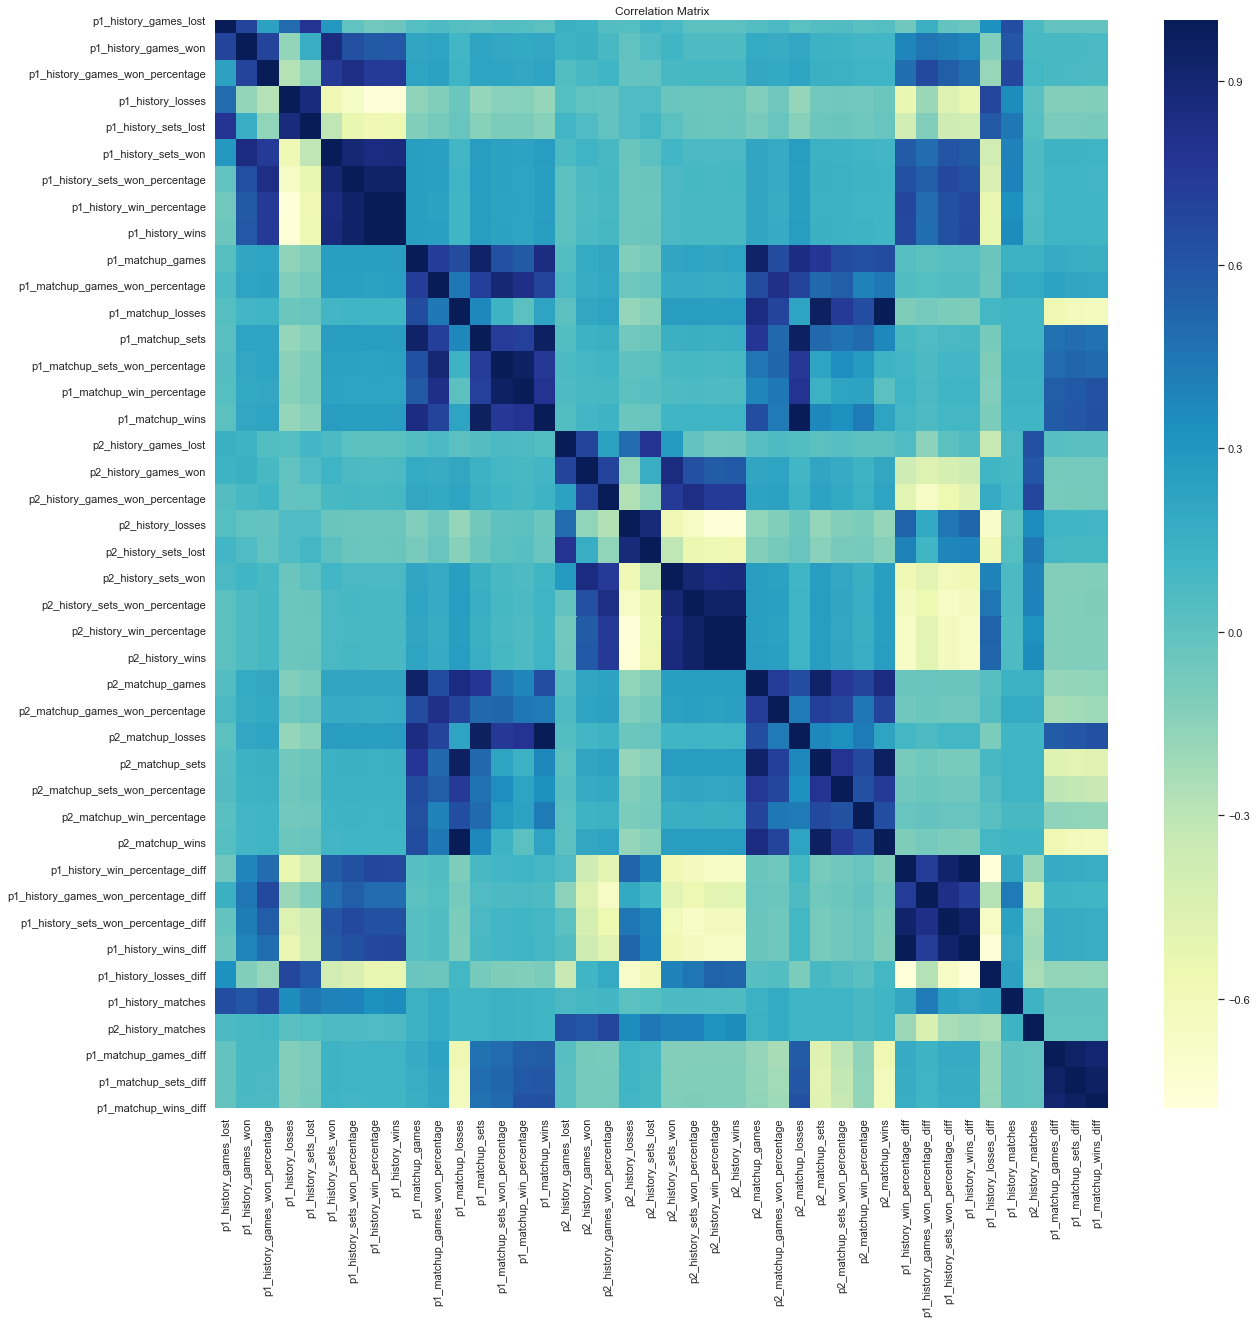

In [77]:
# correlation matrix
f, a = plt.subplots(1, 1, figsize=(20, 20))
_ = sns.heatmap(scores.corr(), cmap="YlGnBu")
_ = a.set_title("Correlation Matrix")

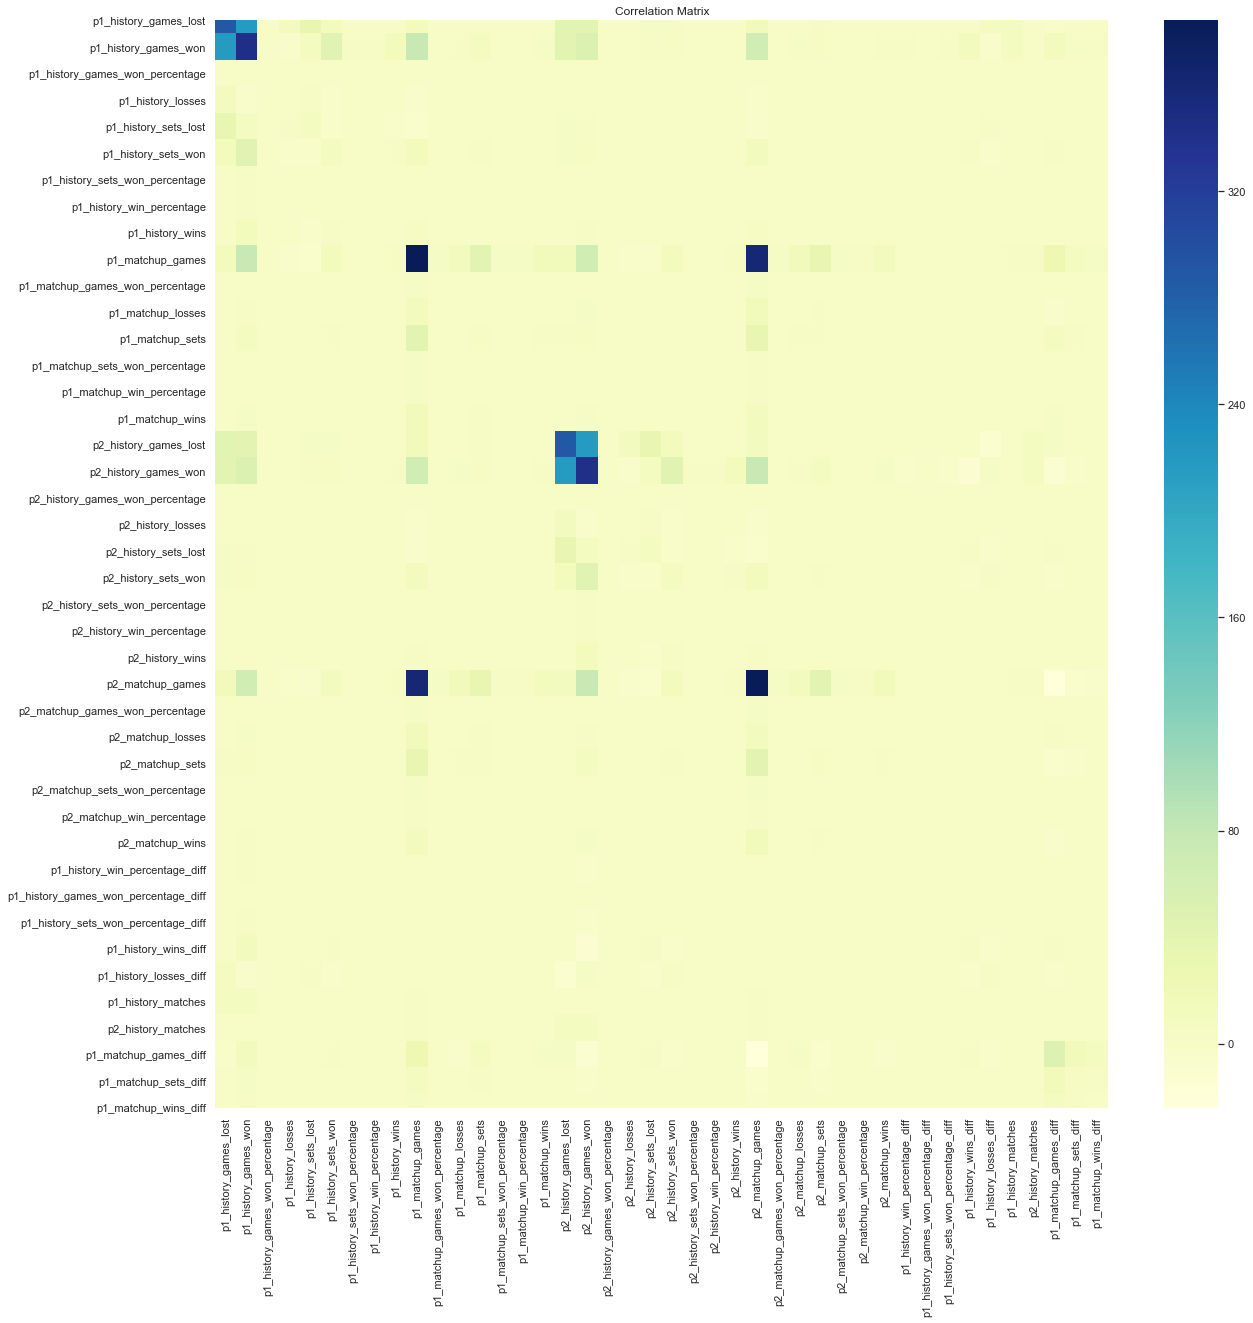

In [78]:
# coveriance matrix
f, a = plt.subplots(1, 1, figsize=(20, 20))
_ = sns.heatmap(scores.cov(), cmap="YlGnBu")
_ = a.set_title("Correlation Matrix")

## Player History
* most players are coming into the match with 5 historical matches
* most players are coming into the match with a lossing record as you see most are coming in with a win of 2 or less matches
* player 1 is mostly coming into the match with a worse record than player 2 as you see most values at <=0 in Historical Win Percentage Diff

### Matchups
* 65% of players are coming in without a previous matchup
* If the players have played before, player 1 is mostly coming into a matchup with a lossing record

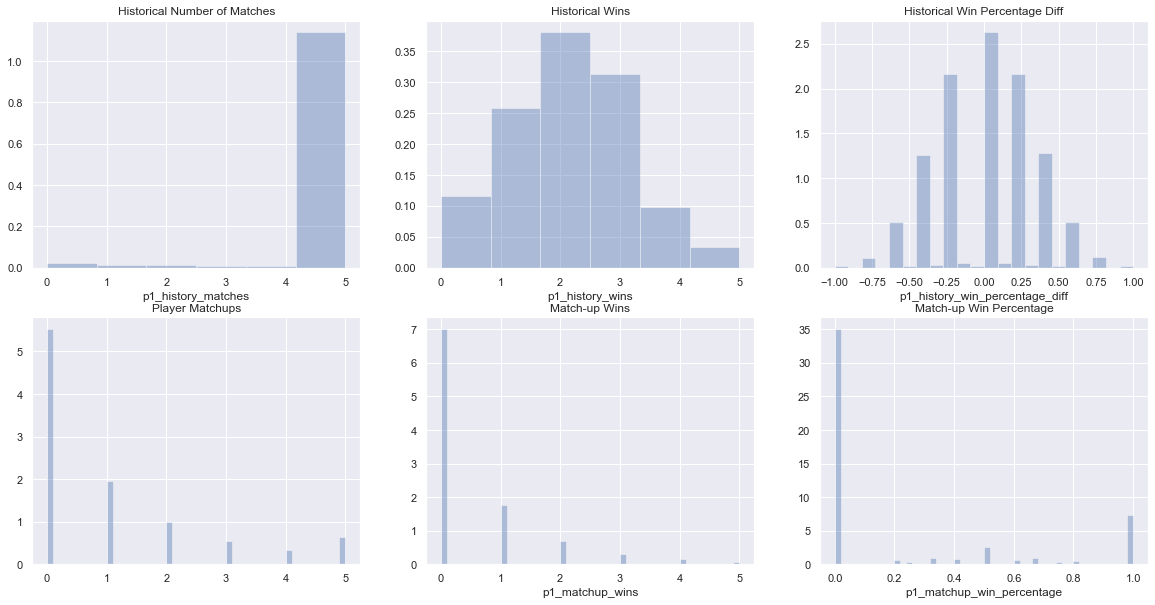

In [115]:
# distribution of player with matches
f, a = plt.subplots(2, 3, figsize=(20, 10))
sns.distplot(scores.p1_history_matches, ax=a[0][0], bins=6, norm_hist=True, kde=False)
a[0][0].set_title("Historical Number of Matches")

sns.distplot(scores.p1_history_wins, ax=a[0][1], bins=6, norm_hist=True, kde=False)
a[0][1].set_title("Historical Wins")

sns.distplot(scores.p1_history_win_percentage_diff, ax=a[0][2], bins=22, norm_hist=True, kde=False)
_ = a[0][2].set_title("Historical Win Percentage Diff")


sns.distplot(scores.p1_matchup_wins + scores.p2_matchup_wins, ax=a[1][0], norm_hist=True, kde=False)
_ = a[1][0].set_title("Player Matchups")

sns.distplot(scores.p1_matchup_wins, ax=a[1][1], norm_hist=True, kde=False)
_ = a[1][1].set_title("Match-up Wins")

sns.distplot(scores.p1_matchup_win_percentage, ax=a[1][2], norm_hist=True, kde=False)
_ = a[1][2].set_title("Match-up Win Percentage")
